# RadioML Receiver

## A Recurrent Neural Network for Learning to demodulate and decode noisy signals over AWGN Channel.

___

# Environment Setup

Download & install and import packages for this tutorial


In [1]:
#@title Click here to run set up { display-mode: "form" }
#@test {"output": "ignore"}

!pip install pydot  > /dev/null 2>&1

# Download and Install Commpy
!rm -rf CommPy && git clone --quiet https://github.com/datlife/CommPy
!cd CommPy && python setup.py install > /dev/null 2>&1

# Download and Install DeepCom
!rm -rf radioml && git clone --quiet https://github.com/datlife/radioml
!mv radioml ./backup && mv backup/radioml radioml

# Import local module
import time
import sys
sys.path.append('radioml')

import multiprocessing as mp
import random 
import numpy as np
import commpy as cp
from commpy.channelcoding import Trellis
from commpy.modulation import QAMModem, PSKModem

# For baseline comparision
from radioml.demodulators import ClassicDemodulator
from radioml.decoders import ViterbiDecoder
from radioml.radio_receivers import ModularReceiver, End2EndReceiver
import radioml.utils as radioml_utils

# For end2end receiver
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.layers import GRU, Bidirectional, TimeDistributed

# For visualization
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()

print("\nEnvironment setup is completed.")


Environment setup is completed.


# Define parameters for this experiment

In [0]:
DATA_LENGTH  = 100
SNR_TRAIN    = 10.0 


NUM_EXAMPLES = 1000 # 200k examples
SNR          = SNR_TRAIN 
modem = QAMModem(4) 
trellis = Trellis(memory   = np.array([2]), 
                  g_matrix = np.array([[0o7, 0o5]]) , 
                  feedback = 0o7)

# Dataset Prepartion

## Define functions for data generator/transformation.


In [0]:
def generate_signal_over_awgn(modem, data_length=100, snr_dB=15.0):
    """Simulate Data sending over AWGN Channel."""
    
    message_bits   = np.random.randint(0, 2, data_length)
    encoded_bits   = cp.channelcoding.conv_encode(message_bits, trellis)
    modulated_bits = modem.modulate(encoded_bits)
    corrupted_bits = cp.channels.awgn(modulated_bits, snr_dB, rate=1/2)
    return message_bits, modulated_bits, corrupted_bits

def signal_generator(modulation_scheme, num_examples, data_length, snr_dB, 
                     seed=2018):
    """A generator to generate NUM_SAMPLES data points."""
    
    np.random.seed(seed)
    with mp.Pool(mp.cpu_count()) as pool:
        result = pool.starmap(generate_signal_over_awgn,
                iterable=[(modulation_scheme, data_length, snr_dB) \
                          for i in range(num_examples)])
        orignal_msg_bits, moded_bits, noisy_outputs = zip(*result)
    np.random.seed()
    return (np.array(orignal_msg_bits), np.array(moded_bits), np.array(noisy_outputs))
  
 
def get_trainable_data(x, y):
    """Encode complex numbers to trainable data and one_hot labels"""
    x = np.array(x)[:, :100]
    y = np.array(y)
    x = np.stack((x.real, x.imag), axis=-1)
    y = np.expand_dims(y, -1)  # (batch, data_length, 1)
    return x, y

## Generate training/dev/test dataset


Training data
Trainable data: (800, 100, 2) (100, 100, 2) (100, 100, 2)
Groundtruths  : (800, 100, 1) (100, 100, 1) (100, 100, 1)



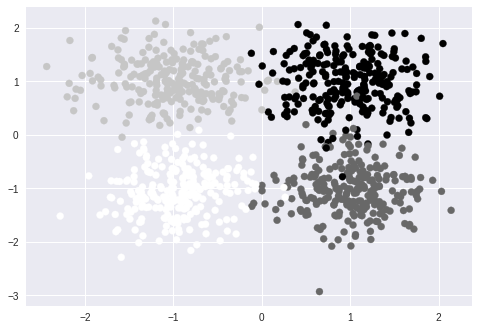

In [4]:
# Generate data for training
original_bits, clean_signals, noisy_signals = signal_generator(modem, NUM_EXAMPLES, DATA_LENGTH, SNR)

# Split data into train/dev/test
dataset = list(zip(noisy_signals, 
                   original_bits))

# A trick to make sure test/dev have similar distribution
split1 = int(0.8 * len(dataset))
split2 = int(0.9 * len(dataset))
train_set = dataset[:split1]
dev_set = dataset[split1:split2]
test_set = dataset[split2:]

# Split data
x_train, y_train = zip(*train_set)
x_dev, y_dev = zip(*dev_set)
x_test, y_test = zip(*test_set)

# Transform (or encode complex inputs) data into trainable features
X_train, Y_train = get_trainable_data(x_train, y_train)
X_dev, Y_dev = get_trainable_data(x_dev, y_dev)
X_test, Y_test = get_trainable_data(x_test, y_test)

print('Training data')
print('Trainable data:', X_train.shape, X_dev.shape, X_test.shape)
print('Groundtruths  :', Y_train.shape, Y_dev.shape, Y_test.shape)
print()


## Visualize a subset of data
inputs = noisy_signals.flatten()[0:1000]
_, groundtruths = np.unique(clean_signals, return_inverse=True)
_ = plt.scatter(np.real(inputs), np.imag(inputs), c=groundtruths[0:1000])

#  Compute baseline performance (Classic Demodulation + Viterbi)


In [5]:
baseline_receiver = ModularReceiver(ClassicDemodulator(modem),
                                    ViterbiDecoder(trellis, tb_depth=15))

with mp.Pool(mp.cpu_count()) as pool:
    baseline_estimated = pool.map(baseline_receiver, [i for i in x_dev])

ber, bler = radioml_utils.get_ber_bler(np.array(baseline_estimated)[:, :100], y_dev)
print('Optimal BER: %.4f' % ber)
print('Optimal BLER: %.5f' % bler)

Optimal BER: 0.0003
Optimal BLER: 0.02000


 # Construct a Recurrent  Neural Network (2-layer Bidirectional GRU )
 
 
Here we implement an RNN that will read encoded complex inputs and estimate the orignal message bits

In [6]:
num_hidden_layers = 2
hidden_units = 400
dropout = 0.3

# To avoid accidenttally run this cell multiple times.
tf.keras.backend.clear_session()

inputs  = Input(shape=(None, 2))
x = inputs
# Network Architecture
for _ in range(num_hidden_layers):
    x = Bidirectional(GRU(hidden_units,return_sequences=True, recurrent_dropout=dropout))(x)
    x = BatchNormalization()(x)
outputs = TimeDistributed(Dense(1, activation='sigmoid'))(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 800)         967200    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 800)         3200      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 800)         2882400   
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 800)         3200      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           801       
Total params: 3,856,801
Trainable params: 3,853,601
Non-trainable params: 3,200
______________________________________________________________

## Define Loss Function / Metrics (BER/BLER) for training.

In [7]:
def BER(y, y_pred):
    hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
    return tf.reduce_sum(hamming_distances) / tf.size(y)

def BLER(y, y_pred):
    num_blocks_per_batch = tf.cast(tf.shape(y)[0], tf.int64)
    hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
    return tf.count_nonzero(tf.reduce_sum(hamming_distances, axis=1)) / num_blocks_per_batch

model.compile('adam','mse', metrics=[BER, BLER])
model.fit(X_train, Y_train, 
          validation_data=(X_dev, Y_dev), 
          epochs=3, batch_size=512)

Train on 800 samples, validate on 100 samples
Epoch 1/3
800/800 [==============================] - 9s 11ms/step - loss: 0.2531 - BER: 0.3906 - BLER: 1.0000 - val_loss: 0.1814 - val_BER: 0.1616 - val_BLER: 1.0000
Epoch 2/3
800/800 [==============================] - 4s 4ms/step - loss: 0.1208 - BER: 0.1369 - BLER: 1.0000 - val_loss: 0.1483 - val_BER: 0.1164 - val_BLER: 1.0000
Epoch 3/3
800/800 [==============================] - 4s 4ms/step - loss: 0.0773 - BER: 0.0881 - BLER: 1.0000 - val_loss: 0.1271 - val_BER: 0.0750 - val_BLER: 1.0000


# Evaluate on Test Set (100K Examples) at $SNR_{train}$

In [10]:
# ############################
# Baseline Receiver
# ############################
with mp.Pool(mp.cpu_count()) as pool:
    baseline_estimated = pool.map(baseline_receiver, [i for i in x_test])
    
print('[Baseline]    BER = %.8f, BLER = %.8f' % \
      radioml_utils.get_ber_bler(np.array(baseline_estimated)[:, :100], y_test))

# ############################
# ML Receiver
# ############################
predictions = model.predict(X_test, batch_size=512)
ml_estimated = np.squeeze(predictions, -1).round()

print('[ML Receiver] BER = %.8f, BLER = %.8f' % \
      radioml_utils.get_ber_bler(ml_estimated, y_test))


[Baseline]    BER = 0.00030000, BLER = 0.02000000
[ML Receiver] BER = 0.07140000, BLER = 1.00000000


# Evaluate on multiple $SNRs$.

In [12]:
model.save('end2end.hdf5')
end2end_receiver = End2EndReceiver('end2end.hdf5', data_length=100)

class Params:
    SNR_RANGE = [0.0, 3.0, 5.0, 7.0, 9.0, 10.0, 11.0, 13.0]
    NUM_SAMPLES = 100
    BLOCK_LENGTH = 100
    BPSK, QPSK, QAM16, QAM64 = 2, 4, 16, 64
    
    
ber_logs, bler_logs = [], []
for i, snr in enumerate(Params.SNR_RANGE):
    print('SNR_dB = %f' % snr)
    
    (original_bits, _, noisy_signals) = signal_generator(
        modem,
        Params.NUM_SAMPLES, 
        Params.BLOCK_LENGTH, 
        snr)
    
    # Run Baseline/Neral Receiver
    t1 = time.time()
    with mp.Pool(mp.cpu_count()) as pool:
        baseline_estimated = pool.map(baseline_receiver, [i for i in noisy_signals])
        
    t2 = time.time()
    
    nn_estimated = end2end_receiver(np.array(noisy_signals)[:, :100], 128)
    
    t3 = time.time()
    
    # Measure BER / BKER for two receivers
    ber, bler = radioml_utils.get_ber_bler(np.array(baseline_estimated)[:, :100], original_bits)
    nn_ber, nn_bler = radioml_utils.get_ber_bler(nn_estimated, original_bits)
    print('\t[Modular]  Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(nn_ber, nn_bler, t2 - t1))
    print('\t[Baseline] Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(ber, bler, t3-t2))
    
    ber_logs.append([ber, nn_ber])
    bler_logs.append([bler, nn_bler])
    

SNR_dB = 0.000000
	[Modular]  Ber = 0.27190000 | Bler =1.00000000 - 2.86008s
	[Baseline] Ber = 0.27920000 | Bler =1.00000000 - 0.86210s
SNR_dB = 3.000000
	[Modular]  Ber = 0.20520000 | Bler =1.00000000 - 2.85863s
	[Baseline] Ber = 0.16840000 | Bler =1.00000000 - 0.33339s
SNR_dB = 5.000000
	[Modular]  Ber = 0.16200000 | Bler =1.00000000 - 2.86831s
	[Baseline] Ber = 0.07330000 | Bler =0.99000000 - 0.32742s
SNR_dB = 7.000000
	[Modular]  Ber = 0.12260000 | Bler =1.00000000 - 2.96037s
	[Baseline] Ber = 0.01540000 | Bler =0.38000000 - 0.33366s
SNR_dB = 9.000000
	[Modular]  Ber = 0.08810000 | Bler =1.00000000 - 2.96238s
	[Baseline] Ber = 0.00140000 | Bler =0.06000000 - 0.33037s
SNR_dB = 10.000000
	[Modular]  Ber = 0.07320000 | Bler =1.00000000 - 2.86040s
	[Baseline] Ber = 0.00100000 | Bler =0.04000000 - 0.32493s
SNR_dB = 11.000000
	[Modular]  Ber = 0.06670000 | Bler =1.00000000 - 2.86192s
	[Baseline] Ber = 0.00040000 | Bler =0.02000000 - 0.32640s
SNR_dB = 13.000000
	[Modular]  Ber = 0.0459000

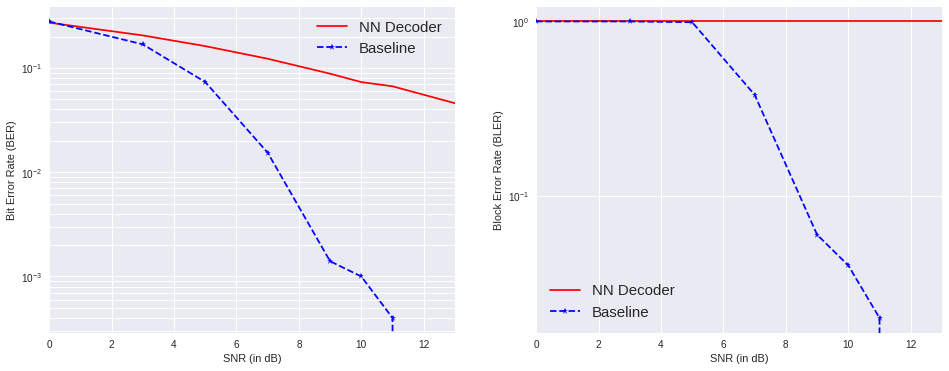

In [18]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
radioml_utils.visualize_ber_bler(ax1, ax2, ber_logs, bler_logs, Params.SNR_RANGE)
ax1.semilogy()
_=ax2.semilogy()